In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns

In [2]:
# data import
iris = load_iris()
X = iris.data
y = iris.target

In [3]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [4]:
# dataset
class IrisData(Dataset):
    def __init__(self, X_train, y_train) -> None:
        super().__init__()
        self.X = torch.from_numpy(X_train)
        self.y = torch.from_numpy(y_train)
        self.y = self.y.type(torch.LongTensor)
        self.len = self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.len

In [5]:
# dataloader
iris_data = IrisData(X_train=X_train, y_train=y_train)
train_loader = DataLoader(dataset=iris_data, batch_size=32, shuffle=True)

In [6]:
# check dims
print(f"X Shape: {iris_data.X.shape}, y shape: {iris_data.y.shape}")

X Shape: torch.Size([120, 4]), y shape: torch.Size([120])


In [7]:
# define class
class MultiClassNet(nn.Module):
    def __init__(self, NUM_FEATURES, NUM_CLASSES, HIDDEN_FEATURES):
        super().__init__()
        self.lin1 = nn.Linear(NUM_FEATURES, HIDDEN_FEATURES)
        self.lin2 = nn.Linear(HIDDEN_FEATURES, NUM_CLASSES)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.lin1(x)
        x = torch.sigmoid(x)
        x = self.lin2(x)
        x = self.log_softmax(x)
        return x

In [8]:
# hyper parameters
NUM_FEATURES = iris_data.X.shape[1]
HIDDEN = 6
NUM_CLASSES = len(iris_data.y.unique())

In [9]:
# create model instance
model = MultiClassNet(NUM_FEATURES=NUM_FEATURES, NUM_CLASSES=NUM_CLASSES, HIDDEN_FEATURES=HIDDEN)

In [10]:
# loss function
criterion = nn.CrossEntropyLoss()

In [11]:
# optimizer
lr = 0.1
optimizer=torch.optim.SGD(model.parameters(), lr=lr)

In [12]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# model.to(device)
# y_test = y_test.to(device)

In [13]:
# training
NUM_EPOCHS = 100
losses = []
for epoch in range(NUM_EPOCHS):
    for x, y in train_loader:

        # initialize gradients
        optimizer.zero_grad()

        # forward pass
        y_hat_log = model(x)

        # calculate losses
        loss = criterion(y_hat_log, y)

        # calculate gradients

        loss.backward()
        # update parameters
        optimizer.step()

    losses.append(float(loss.data.detach().numpy()))

<Axes: >

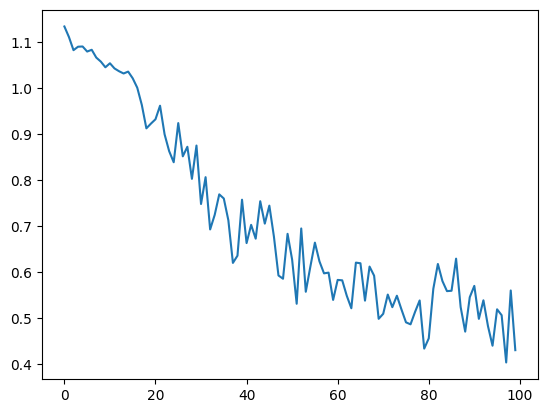

In [14]:
# show losses over epochs
sns.lineplot(x= range(len(losses)), y = losses)

In [15]:
# test the model
X_test_torch = torch.from_numpy(X_test)
with torch.no_grad():
    y_test_hat_softmax = model(X_test_torch)
    y_test_hat = torch.max(y_test_hat_softmax.data, 1)

In [16]:
# Accuracy
accuracy_score(y_test, y_test_hat.indices.numpy())

1.0